## Hidden Markov Models for Stock Prediction

*Some changes over the hmmlearn example.*

### Get Quotes and Plot

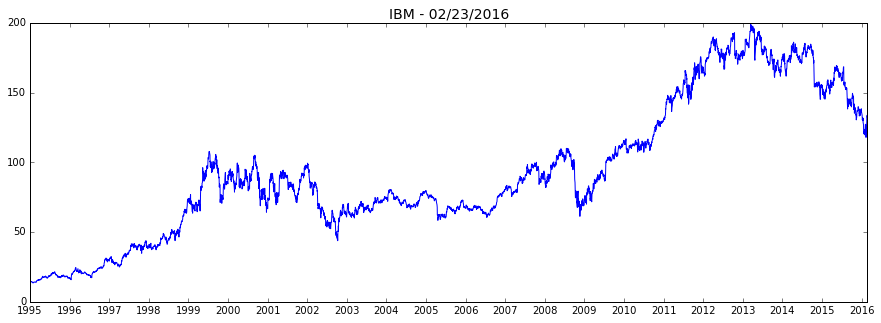

In [1]:
"""
Gaussian HMM of stock data
--------------------------
This script shows how to use Gaussian HMM on stock price data from Yahoo! finance.
"""
%matplotlib inline

from __future__ import print_function
import datetime
import numpy as np
import pandas as pd
from matplotlib import cm, pyplot as plt, finance
from matplotlib.dates import YearLocator, MonthLocator
from hmmlearn.hmm import GaussianHMM

###############################################################################
# Get quotes from Yahoo! finance
###############################################################################
ticker = "IBM"
start_date = datetime.date(1995, 1, 1)
#end_date = datetime.date.today()
end_date = datetime.date.today() - datetime.timedelta(days=15)
quotes = finance.quotes_historical_yahoo_ochl(ticker, start_date, end_date)

# Unpack quotes
dates = np.array([q[0] for q in quotes], dtype=int)
close_v = np.array([q[2] for q in quotes])
volume = np.array([q[5] for q in quotes])[1:]

# Take diff of close value. Note that this makes
# ``len(diff) = len(close_t) - 1``, therefore, other quantities also
# need to be shifted by 1.
diff = np.diff(close_v)
dates = dates[1:]
close_v = close_v[1:]

# Pack diff and volume for training.
X = np.column_stack([diff, volume])
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker + " - " + end_date.strftime("%m/%d/%Y"), fontsize = 14)
plt.gca().xaxis.set_major_locator(YearLocator())
plt.plot_date(dates,close_v,"-")
plt.show()

### Fit HMM and calculate State Transition Matrix

In [2]:
###############################################################################
# Run Gaussian HMM
###############################################################################
print("fitting to HMM and decoding ...", end="")
# Make an HMM instance and execute fit
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)
# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)
print("done")

###############################################################################
# Print trained parameters and plot
###############################################################################
print("Transition matrix - probability of going to any particular state")
print(model.transmat_)

print("Means and vars of each hidden state")
params = pd.DataFrame(columns=('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i],np.diag(model.covars_[i])]

fitting to HMM and decoding ...done
Transition matrix - probability of going to any particular state
[[  8.68626404e-01   5.59087743e-02   3.48333091e-02   4.06315127e-02]
 [  7.15448324e-02   9.12937833e-01   1.55172848e-02   4.98241907e-08]
 [  7.16808699e-02   3.91791775e-02   5.34970304e-01   3.54169649e-01]
 [  1.02368273e-01   2.73692726e-12   1.27063337e-01   7.70568390e-01]]
Means and vars of each hidden state


### Plot states 

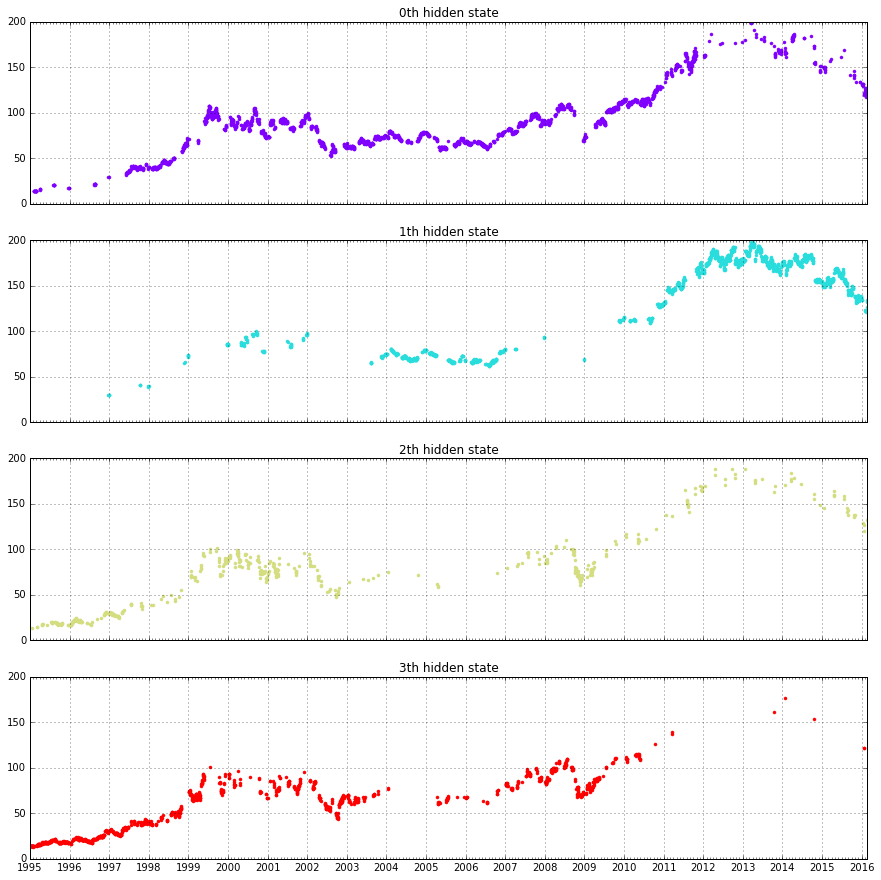

In [3]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)
plt.show()

### Returns by hidden states

In [4]:
#dot product Transition Matrix to Means to get the expected return and volumes for a particular state
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_columnwise[0]
expected_volumes = returns_and_volume_columnwise[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis=1)
params.columns= ['Returns', 'Volume']
print (params)

    Returns           Volume
0  0.054290   6856059.629227
1  0.027051   4376962.253406
2 -0.101425  12967155.313014
3  0.015756  10700647.997504


### Predict Stock price for last N days

In [5]:
#get quotes for last N days
lastN = 7
start_date = datetime.date.today() - datetime.timedelta(days=lastN*2) #even beyond N days
end_date = datetime.date.today() 
quotes = finance.quotes_historical_yahoo_ochl(ticker,start_date,end_date)
dates = np.array([q[0] for q in quotes], dtype=int)

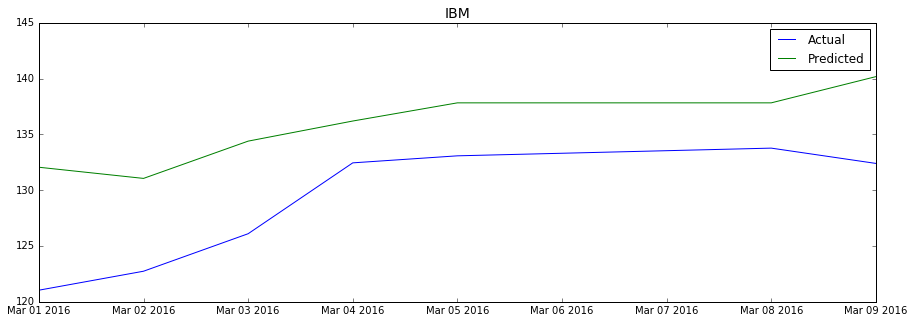

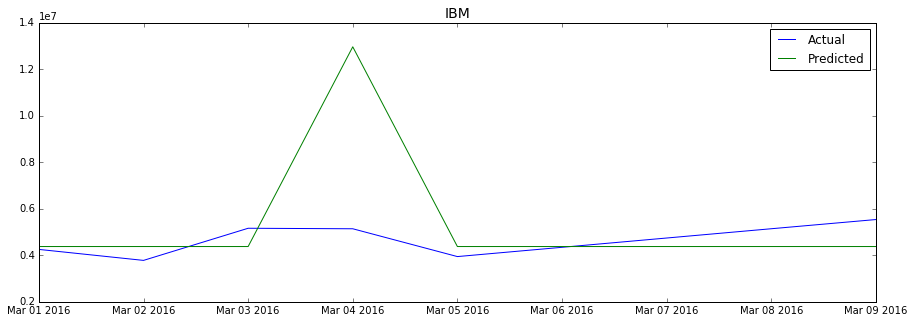

In [7]:
predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []

for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = quotes[-lastN+idx][2]
    volume = quotes[-lastN+idx][5]
    actual_volumes.append(volume)
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))    

#Returns
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,close_v[-lastN:])
plt.plot(predicted_dates,predicted_prices)
plt.legend(['Actual','Predicted'])
plt.show()

#Volumes
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,actual_volumes)
plt.plot(predicted_dates,predicted_volumes)
plt.legend(['Actual','Predicted'])
plt.show()